In [1]:
import os, pandas
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from basic_functions_gaussian import numerical_props, analytical_props, flatten, my_group_fun

In [3]:
from basic_functions_bayesian import compute_single, compute, run_Metropolis
from basic_functions_gaussian import loss_fun

### `compute_depth` class

In [8]:
n_frames = int(1e6)
n_obs = 1
sigma = np.ones(n_obs)
gexp = 1.5*np.ones(n_obs)
sigma_exp = 0.3*np.ones(n_obs)
alpha = 0.5

res = numerical_props(n_frames, sigma, gexp, sigma_exp, alpha, n_perim=25)

In [9]:
res2 = analytical_props(n_frames, sigma, gexp, sigma_exp, alpha)



In [10]:
res

           dV: 108.64077633619308
            g: array([[-0.9949906 ,  2.04376564,  2.30709739, ..., -0.63112911,
                        0.86392168,  0.19966175]])
         gbar: 5.7905585311738195
     lim_chi2: [DeviceArray(204.54298, dtype=float32), DeviceArray(392.00778, dtype=float32)]
      lim_dkl: [DeviceArray(13.815479, dtype=float32), DeviceArray(11.239773, dtype=float32)]
     lim_loss: [array([109.17938033]), array([212.70197335])]
 lim_loss_num: [DeviceArray(109.17923, dtype=float32), DeviceArray(201.62378, dtype=float32)]
      min_avg: array([1.437521])
   min_lambda: array([-1.43527241])
     min_loss: 0.5384534001350403
         mini:       fun: 0.5384534001350403
                hess_inv: array([[0.07201769]])
                     jac: array([-4.172325e-07], dtype=float32)
                 message: 'Optimization terminated successfully.'
                    nfev: 6
                     nit: 5
                    njev: 6
                  status: 0
                 su

In [11]:
res2

         dV: array([53.75030909])
       gbar: 5.256521769756932
    gbar_1d: array([4.75342431])
   lim_chi2: array([117.60855259])
    lim_dkl: 13.815510557964274
  lim_value: array([65.71203158])
    min_avg: array([1.4354067])
    min_dkl: 1.0301961951420529
 min_lambda: array([-1.4354067])
   min_loss: 11.961722488038284

In [1]:
n_obs

NameError: name 'n_obs' is not defined

In [85]:
res

           dV: DeviceArray(11.217223, dtype=float32)
            g: array([[-5.76225347e-01,  6.52010511e-01, -2.17714350e-01,
                        1.40627729e-01,  1.13859260e+00, -6.93891151e-01,
                       -4.49411650e-02, -1.65530679e+00,  7.97499969e-01,
                       -9.67515827e-02, -3.39478243e-01,  2.83242843e+00,
                       -2.62901083e-01, -1.99767026e-01, -1.89186013e+00,
                        2.01825838e-01, -8.74723797e-01,  2.80287295e+00,
                       -1.81552794e+00, -1.47446010e+00, -2.41037142e+00,
                        1.10428504e+00, -9.26123245e-01, -6.45574590e-01,
                       -7.68823696e-01,  1.17149506e+00, -3.19286488e-01,
                        9.34508735e-01, -5.07358977e-01, -1.02577353e+00,
                       -2.26274582e+00, -4.70670964e-02,  4.58055692e-01,
                        5.25225924e-01, -1.95863823e-01, -2.66309165e+00,
                        4.75800690e-01, -1.02390140e-01,  1

In [82]:
res

           dV: 15.799581468105316
            g: array([[-1.64004259e-01, -3.48426590e-01, -1.68904023e+00,
                       -2.73137021e-01, -2.40243025e-01,  4.13890621e-01,
                       -1.43750452e+00, -6.19908401e-01,  9.73102838e-02,
                       -4.90363207e-01, -6.75604958e-01,  2.77216994e-02,
                       -2.08334517e+00,  5.61620419e-01,  1.60664315e-01,
                        2.09699542e-01,  2.66558591e+00, -2.45651614e+00,
                       -4.18585122e-01,  1.19674503e+00,  5.63595457e-01,
                        9.89843293e-01,  7.76967031e-01,  1.49088731e-01,
                        4.01409878e-01,  1.44728668e+00, -8.42790229e-01,
                        1.28053518e+00,  1.21763304e+00, -9.83851386e-01,
                        8.43606041e-01,  1.51505600e+00, -9.87996485e-01,
                        1.31781771e+00, -1.51213504e-01,  8.47228097e-02,
                        1.73231871e+00,  1.70019706e-01,  2.33785862e+00,
    

In [78]:
compute_depth_analytical(n_frames, sigma, gexp, sigma_exp, alpha)

In [77]:
res

           dV: 1.9421740770339966
            g: array([[ 0.92764076, -1.05738705, -0.0214432 , ...,  1.43100926,
                        0.25806425, -0.87918772],
                      [ 0.91208976,  1.33216454,  1.03353804, ...,  0.05126749,
                       -0.53942652, -0.8645546 ],
                      [-0.93138006, -0.28922174,  1.14310178, ...,  0.03063124,
                       -0.14932712, -0.34090486]])
     lim_chi2: DeviceArray(2.2293231, dtype=float32)
      lim_dkl: DeviceArray(5.386307, dtype=float32)
        lim_g: array([1.40981241, 2.02333672, 1.8502001 ])
 lim_loss_num: 3.807815
        lim_p: DeviceArray([1.90248013e-12, 1.32371604e-17, 5.40336059e-13,
                            1.60741934e-25, 8.29056031e-25, 3.27008316e-11,
                            3.42256898e-30, 4.70380656e-17, 5.65313601e-16,
                            1.67831609e-22, 6.11182954e-21, 8.36996708e-15,
                            1.43166238e-22, 7.77072217e-25, 7.78633402e-24,
       

In [66]:
delta_lambda = 10
n_perim = 100
p0 = np.ones(n_frames)/n_frames
g = res.g  # res is self


perimeter = build_perimeter(res.min_lambda, delta_lambda, n_perim)
print('done perimeter')

out = []

for i in range(10000): # perimeter.shape[1]):
    out.append(loss_fun(perimeter[:, i], p0, g, gexp, sigma_exp, alpha, False))

done perimeter


In [65]:
loss_fun(perimeter[:, 0], p0, g, gexp, sigma_exp, alpha, False)

DeviceArray(17.11511, dtype=float32)

In [59]:
perimeter.shape[1]

60000

In [57]:
out[0]

(DeviceArray(17.11511, dtype=float32),
 DeviceArray(27.393497, dtype=float32),
 DeviceArray(6.8367233, dtype=float32),
 DeviceArray([1.21143085e-22, 0.00000000e+00, 2.00561612e-32,
              0.00000000e+00, 7.24241907e-25, 1.70955826e-22,
              6.71762014e-31, 0.00000000e+00, 2.86803756e-26,
              3.51087700e-30, 0.00000000e+00, 6.00173937e-28,
              4.72383081e-35, 0.00000000e+00, 1.51202343e-27,
              2.38668852e-29, 0.00000000e+00, 7.30006668e-30,
              2.73633057e-29, 4.85618195e-30, 6.90526834e-29,
              3.26919517e-20, 1.71222888e-28, 7.88283514e-32,
              1.88070604e-09, 2.11944276e-33, 4.51669692e-30,
              2.47866644e-24, 0.00000000e+00, 1.04642287e-32,
              6.59195632e-33, 0.00000000e+00, 5.69407921e-33,
              3.82080056e-09, 6.67825010e-30, 0.00000000e+00,
              2.18636791e-28, 2.93456405e-32, 0.00000000e+00,
              0.00000000e+00, 4.73697024e-19, 2.67993641e-30,
             

In [42]:
build_perimeter(out.min_lambda, 10).shape

(3, 60000)

In [32]:
out

           dV: 3.465268611907959
            g: array([[ 0.09748559, -2.56350784, -0.62235321, ...,  0.84251299,
                       -1.36348341,  1.71953155],
                      [-0.42690032, -0.00993062,  2.23984181, ...,  2.30601742,
                       -0.37141496,  0.28660309]])
     lim_chi2: DeviceArray(3.858717, dtype=float32)
      lim_dkl: DeviceArray(5.4777603, dtype=float32)
        lim_g: array([1.17940333, 2.95506921])
 lim_loss_num: 4.6682386
        lim_p: DeviceArray([7.70872942e-20, 4.75623440e-32, 2.56363913e-13,
                            6.52718169e-28, 1.36251554e-09, 1.24289752e-14,
                            1.51468466e-17, 2.75113709e-14, 5.33591724e-19,
                            3.63336133e-16, 1.83201274e-18, 2.44128307e-12,
                            7.10230011e-14, 7.82212037e-21, 4.09835155e-15,
                            5.96764061e-15, 1.10142972e-14, 2.55175204e-23,
                            5.19035227e-13, 9.33761095e-26, 6.98570459e-2

### limit values

In [4]:
alpha = 0.5

sigma = 0.1
gexp = 0.3
sigma_exps = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14]

n = np.int64(1e6)

In [6]:
alpha = 0.5

n_obs = 3
sigma = 0.1*np.ones(n_obs)
gexp = 0.3

sigma_exps = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14]
sigma_exp = sigma_exps[0]*np.ones(n_obs)

n = np.int64(1e4)

dV_th = np.min(compute_depth_analytical(n, sigma, gexp, sigma_exp, alpha).dV)
dV_th

compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=100)

IndexError: tuple index out of range

cycle over different values of $\sigma_{exp}$

In [26]:
out1 = {}
out2 = {}

for sigma_exp in sigma_exps:
    
    print(sigma_exp)

    out1[sigma_exp] = {}
    
    for m in range(30):
        out1[sigma_exp][m] = compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=100)
    
    out2[sigma_exp] = compute_depth_analytical(n, sigma, gexp, sigma_exp, alpha)


0.02
0.04
0.06
0.08
0.1
0.12
0.14


In [22]:
print(vars(out2[sigma_exp]).keys())

out2[sigma_exp].lim_value

dict_keys(['lambda_min', 'avg_min', 'loss_min', 'gbar', 'lim_chi2', 'lim_dkl', 'lim_value', 'dV'])


4.737054039650612

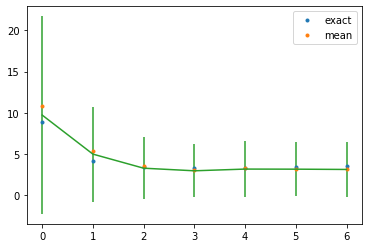

In [24]:
dV_exact = []
dV_num_mean = []
dV_num_std_mean = []

for sigma_exp in out2.keys():
    dV_exact.append(out2[sigma_exp].dV)
    dV_num_mean.append(np.mean([out1[sigma_exp][i].dV for i in out1[sigma_exp].keys()]))
    dV_num_std_mean.append(np.std([out1[sigma_exp][i].dV for i in out1[sigma_exp].keys()])/np.sqrt(len(out1[sigma_exp])))

plt.plot(dV_exact, '.', label='exact')
plt.plot(dV_num_mean, '.', label='mean')
plt.errorbar(np.arange(len(dV_num_mean)), np.array(dV_num_mean) - np.array(dV_num_std_mean), np.array(dV_num_mean) + np.array(dV_num_std_mean))
# plt.fill_between(np.array(dV_num_mean) - np.array(dV_num_std_mean), np.array(dV_num_mean) + np.array(dV_num_std_mean))
# print(dV_exact, dV_num_mean, dV_num_std_mean)

plt.legend()

In [40]:
print(vars(out1[sigma_exp][m]).keys())
print(vars(out2[sigma_exp]).keys())

dict_keys(['g', 'mini', 'min_lambda', 'min_loss', 'min_avg', 'gbar', 'lim_loss', 'lim_loss_num', 'lim_chi2', 'lim_dkl', 'dV'])
dict_keys(['lambda_min', 'avg_min', 'loss_min', 'gbar', 'lim_chi2', 'lim_dkl', 'lim_value', 'dV'])


In [8]:
def compute_mean_std(out, s, j = None):
    
    mean = []
    std_mean = []
    
    for n in out.keys():
        mean.append(np.mean(flatten(out[n], s, j)))
        std_mean.append(np.std(flatten(out[n], s, j))/np.sqrt(len(out[n].keys())))
    
    return mean, std_mean

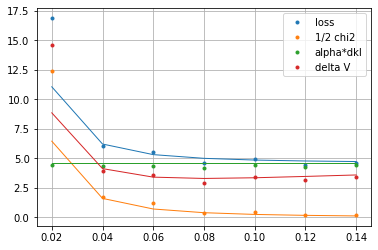

In [41]:
j = 0  # 0 or 1, depending on max/min g

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  # ,'tab:purple','tab:brown','tab:pink',
          #   'tab:gray','tab:olive','tab:cyan']

mean_loss, std_loss = compute_mean_std(out1, 'lim_loss_num', j)
plt.plot(sigma_exps, mean_loss, '.', label='loss', c=colors[0])
plt.plot(sigma_exps, flatten(out2, 'lim_value'), c=colors[0])

mean, std = compute_mean_std(out1, 'lim_chi2', j)
plt.plot(sigma_exps, 1/2*np.array(mean), '.', label='1/2 chi2', c=colors[1])
plt.plot(sigma_exps, 1/2*np.array(flatten(out2, 'lim_chi2')), c=colors[1])

# overestimate of the chi2 with sqrt(log(n))
# plt.plot(sigma_exps, 1/2*((sigma*np.sqrt(2*np.log(sigma_exps)) - gexp)/sigma_exp)**2, label='1/2 chi2 est')

mean, std = compute_mean_std(out1, 'lim_dkl', j)
plt.plot(sigma_exps, alpha*np.array(mean), '.', label='alpha*dkl', c=colors[2])
plt.plot(sigma_exps, alpha*np.array(flatten(out2, 'lim_dkl')), c=colors[2])

mean, std = compute_mean_std(out1, 'dV')
plt.plot(sigma_exps, mean, '.', label='delta V', c=colors[3])
plt.plot(sigma_exps, flatten(out2, 'dV'), c=colors[3])

plt.grid()
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

### Metropolis sampling

In [19]:
p0 = np.ones(n)/n
# g = np.random.normal(0, sigma, size=n)
g = np.random.multivariate_normal(np.zeros(2), sigma*np.identity(2), size=n)

In [44]:
def energy_function(x, p0, g, gexp, sigma_exp, alpha, if_jeffreys = False):

    out = loss_fun(x, p0, g, gexp, sigma_exp, alpha, if_cov=if_jeffreys)

    if if_jeffreys:
        energy = out[0]
        cov = out[-1]
        jeff = np.log(np.linalg.det(cov))
        energy -= jeff

    else:
        energy = out

    return np.array([energy])

Text(0.5, 0, 'n frames')

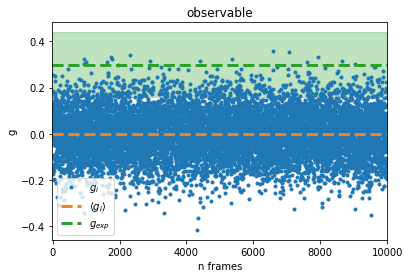

In [45]:
plt.rcParams['lines.linewidth'] = 3

plt.plot(g, '.', label=r'$g_i$')

plt.plot([-5, len(g) + 5], [np.mean(g), np.mean(g)], '--', label=r'$\langle g_i\rangle$')  # ,color='tab:blue')

plt.plot([-5, len(g) + 5], [gexp, gexp], '--', label=r'$g_{exp}$')
plt.fill_between([-5, len(g) + 5], [gexp - sigma_exp, gexp - sigma_exp], [gexp + sigma_exp, gexp + sigma_exp], alpha=0.3, color='tab:green')

plt.title('observable')
plt.legend(loc='lower left')
plt.xlim([-5, len(g) + 5])
plt.ylabel('g')
plt.xlabel('n frames')

In [46]:
dV = compute_depth_analytical(n, sigma, gexp, sigma_exp, alpha).dV

print(dV)

3.6006904032869764


In [47]:
out = compute_depth(n, np.array([g]), gexp, sigma_exp, alpha, if_scan=True, delta_lambda=100)

In [48]:
vars(out).keys()

dict_keys(['g', 'mini', 'min_lambda', 'min_loss', 'min_avg', 'gbar', 'lim_loss', 'lim_loss_num', 'lim_chi2', 'lim_dkl', 'dV', 'scan_lambdas', 'scan_results', 'scan_loss_min', 'scan_lambda_min', 'scan_avg_min'])

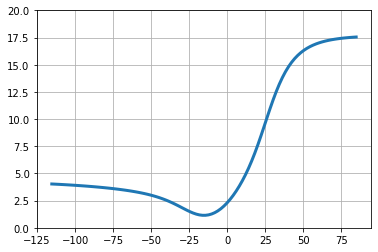

In [49]:
plt.plot(out.scan_lambdas, out.scan_results['lossf'])
plt.ylim([0, 20])
plt.grid()

Text(0.5, 1.0, 'derivative')

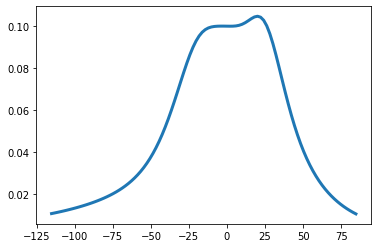

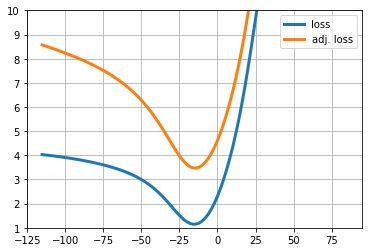

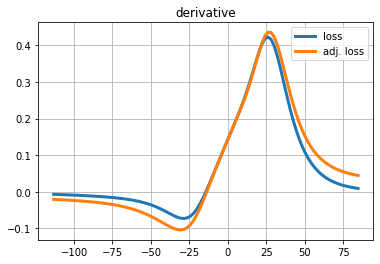

In [50]:
out_compute = compute(out.scan_lambdas, p0, g, gexp, sigma_exp, alpha)

plt.plot(out.scan_lambdas, out_compute['std_g'])

plt.figure()
plt.plot(out.scan_lambdas, out.scan_results['lossf'], label='loss')

adj_loss = out.scan_results['lossf'] - np.log(out_compute['jeffreys'])
plt.plot(out.scan_lambdas, adj_loss, label='adj. loss')
plt.grid()
plt.legend()
# plt.yscale('log')
plt.ylim([1, 10])

plt.figure()

def num_der(x, y):
    dy_dx = np.ediff1d(y)/np.ediff1d(x)
    return dy_dx

plt.plot(out.scan_lambdas[1:], num_der(out.scan_lambdas, out.scan_results['lossf']), label='loss')
plt.plot(out.scan_lambdas[1:], num_der(out.scan_lambdas, adj_loss), label='adj. loss')
plt.grid()
plt.legend()
plt.title('derivative')

In [51]:
my_energy_function = lambda x : energy_function(x, p0, g, gexp, sigma_exp, alpha, False)

out_Metropolis = run_Metropolis(np.zeros(1), 5., my_energy_function, n_steps=10000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [52]:
my_energy_function = lambda x : energy_function(x, p0, g, gexp, sigma_exp, alpha, True)

out_J_Metropolis = run_Metropolis(np.zeros(1), 5., my_energy_function, n_steps=10000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


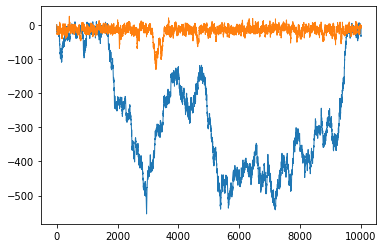

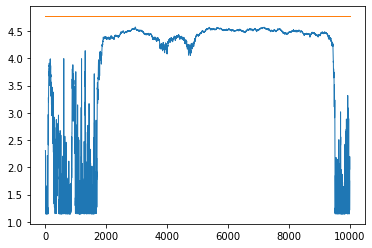

In [53]:
plt.rcParams['lines.linewidth'] = 1

plt.plot(out_Metropolis[0])
plt.plot(out_J_Metropolis[0])

plt.figure()
plt.plot(out_Metropolis[1])
# plt.plot(out_J_Metropolis[1])

# val = out2[sigma_exp].lim_value
val = compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=100).lim_loss[0]
plt.plot([0, len(out_Metropolis[1])], [val, val])

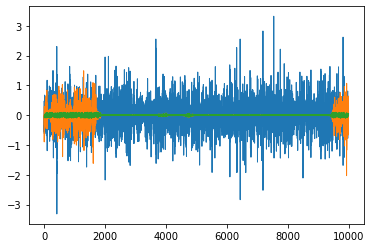

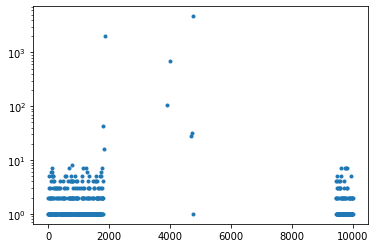

In [69]:
dif = np.ediff1d(out_Metropolis[1])
dif_J = np.ediff1d(out_J_Metropolis[1])

wh = np.where(dif != 0)
wh2 = np.where(np.abs(dif) < 0.1)
wh = np.intersect1d(wh, wh2)

plt.plot(dif_J)
plt.plot(dif)
plt.plot(wh, dif[wh])
# plt.xlim([0, 2000])

gr = my_group_fun(dif, 0, 0.05)

plt.figure()
plt.plot(gr[0], gr[1], '.')
plt.yscale('log')


In [78]:
gr[0][np.where(np.array(gr[1]) > 100)[0][0]]

1855

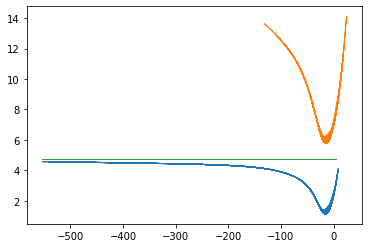

In [54]:
plt.plot(out_Metropolis[0], out_Metropolis[1])
plt.plot(out_J_Metropolis[0], out_J_Metropolis[1])
plt.plot([np.min(out_Metropolis[0]), np.max(out_Metropolis[1])], val*np.ones(2))


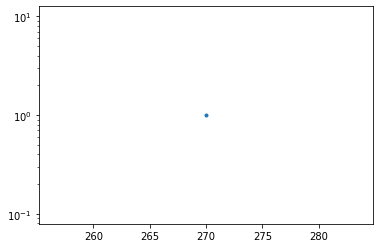

In [23]:
out = my_group_fun(out_Metropolis[1], val, 0.2)

plt.plot(out[0], out[1], '.')
plt.yscale('log')

### Metropolis sampling - cycle over $\sigma_{exp}$ (old)

In [ ]:
out1[sigma_exp][m] = compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=100)

In [80]:
sigma_exps

[0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14]

In [95]:
n_steps = 5000

dV = {}
out = {}
# ind = {}
out_Metropolis = {}
out_J_Metropolis = {}

for sigma_exp in sigma_exps:

    print(sigma_exp)

    dV[sigma_exp] = compute_depth_analytical(n, sigma, gexp, sigma_exp, alpha).dV

    out[sigma_exp] = compute_depth(n, np.array([g]), gexp, sigma_exp, alpha, if_scan=True, delta_lambda=100)
    out_compute = compute(out[sigma_exp].scan_lambdas, p0, g, gexp, sigma_exp, alpha)

    my_energy_function = lambda x : energy_function(x, p0, g, gexp, sigma_exp, alpha, False)

    out_Metropolis[sigma_exp] = run_Metropolis(np.zeros(1), 5., my_energy_function, n_steps=n_steps)

    my_energy_function = lambda x : energy_function(x, p0, g, gexp, sigma_exp, alpha, True)

    out_J_Metropolis[sigma_exp] = run_Metropolis(np.zeros(1), 5., my_energy_function, n_steps=n_steps)

    # dif = np.ediff1d(out_Metropolis[sigma_exp][1])
    # group = my_group_fun(dif, 0, 0.05)
    # ind[sigma_exp] = group[0][np.where(np.array(group[1]) > 100)[0][0]]

    clear_output()

In [102]:
out_Metropolis[0.04]

(array([[  0.        ],
        [  0.        ],
        [ -0.59643111],
        ...,
        [-34.95668034],
        [-31.3548428 ],
        [-31.10781612]]),
 array([28.267906 , 28.267906 , 27.163565 , ...,  2.257364 ,  2.1869173,
         2.1895478], dtype=float32),
 0.8748)

In [96]:
ind = {}

for sigma_exp in out_Metropolis.keys():
    dif = np.ediff1d(out_Metropolis[sigma_exp][1])
    group = my_group_fun(dif, 0, 0.05)
    wh = np.where(np.array(group[1]) > 100)[0]
    if not (len(wh) == 0):
        ind[sigma_exp] = group[0][wh[0]]
    else:
        ind[sigma_exp] = None



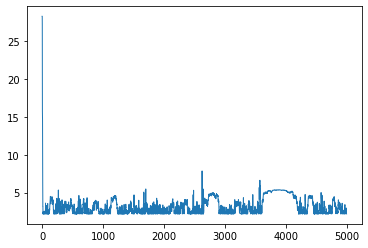

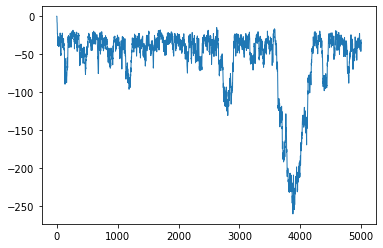

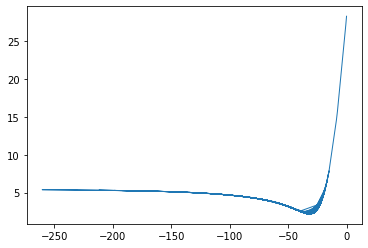

In [101]:
plt.plot(out_Metropolis[0.04][1])

plt.figure()
plt.plot(out_Metropolis[0.04][0])

plt.figure()
plt.plot(out_Metropolis[0.04][0], out_Metropolis[0.04][1])

In [97]:
ind

{0.02: None,
 0.04: 3761,
 0.06: 1844,
 0.08: 3020,
 0.1: None,
 0.12: None,
 0.14: 2025}

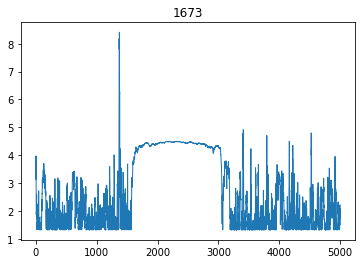

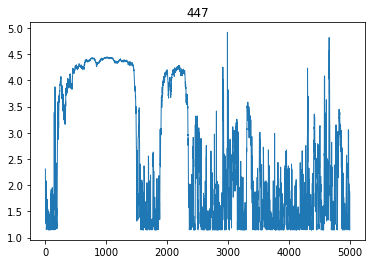

In [85]:
for sigma_exp in sigma_exps[-2:]:
    plt.figure()
    plt.plot(out_Metropolis[sigma_exp][1])
    # plt.title(out[sigma_exp].lim_loss)
    plt.title(ind[sigma_exp])

7.978613733244856


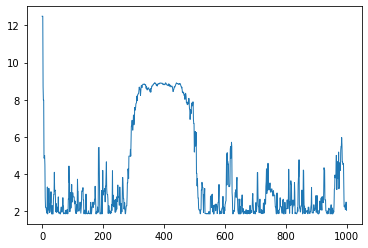

In [97]:
sigma_exp = sigma_exps[-5]

val = out2[sigma_exp].lim_value
print(val)

plt.plot(out_Metropolis[sigma_exp][1])

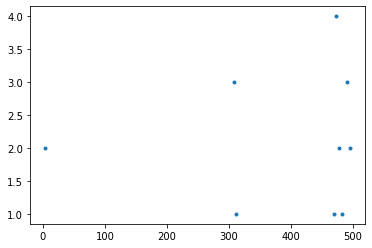

In [99]:
out = my_group_fun(out_Metropolis[sigma_exp][1], val, 0.2)

plt.plot(out[0], out[1], '.')
# plt.yscale('log')

### Metropolis sampling (cycle over $\sigma_{exp}$)

In [47]:
alpha = 0.5

sigma = 0.1
gexp = 0.3
sigma_exp = 0.9

n_frames = np.int64(1e4)

n_steps = np.int64(3e3)
step_length = 5.

seed = 3

In [48]:
rng = np.random.default_rng(seed)

In [49]:
p0 = np.ones(n_frames)/n_frames
g = rng.normal(0, sigma, size=n_frames)

def energy_function(x, p0, g, gexp, sigma_exp, alpha, if_jeffreys = False):

    out = loss_fun(x, p0, g, gexp, sigma_exp, alpha, if_cov=if_jeffreys)

    if if_jeffreys:
        energy = out[0]
        cov = out[-1]
        jeff = np.log(np.linalg.det(cov))
        energy -= jeff

    else:
        energy = out

    return np.array([energy])

In [50]:
result_values = {}

my_energy_function = lambda x : energy_function(x, p0, g, gexp, sigma_exp, alpha, False)

out_Metropolis = run_Metropolis(np.zeros(1), step_length, my_energy_function, n_steps=n_steps)

result_values['accept_noJef'] = out_Metropolis[2]

my_energy_function = lambda x : energy_function(x, p0, g, gexp, sigma_exp, alpha, True)

out_J_Metropolis = run_Metropolis(np.zeros(1), step_length, my_energy_function, n_steps=n_steps)

result_values['accept_Jef'] = out_J_Metropolis[2]

dif = np.ediff1d(out_Metropolis[1])
group = my_group_fun(dif, 0, 0.1)
wh = np.where(np.array(group[1]) > 100)[0]
if not (len(wh) == 0): ind = group[0][wh[0]]
else: ind = None

result_values['diverg_frame'] = ind

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


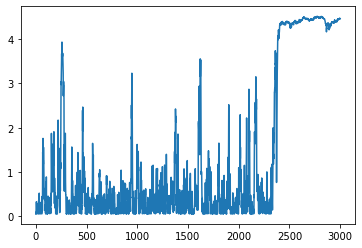

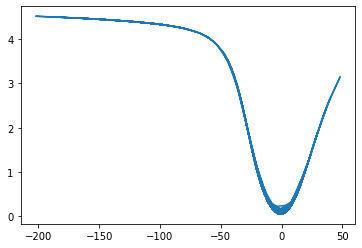

In [51]:
plt.plot(out_Metropolis[1])

plt.figure()
plt.plot(out_Metropolis[0], out_Metropolis[1])

In [52]:
result_values

{'accept_noJef': 0.9176666666666666,
 'accept_Jef': 0.8946666666666667,
 'diverg_frame': 2398}

### Analysis of the results
from calculations in parallel on Ulysses

In [1]:
!scp -r igilardo@frontend2.hpc.sissa.it:/home/igilardo/5_Jeffreys/Metropolis_sampling . 

igilardo@frontend2.hpc.sissa.it's password: 


In [86]:
root_path = '../Metropolis_sampling/'
dir_list = os.listdir(root_path)

temp = []

for s in dir_list:
    df = pandas.read_csv(root_path + s + '/input_pars')
    df2 = pandas.read_csv(root_path + s + '/result_values')
    df = pandas.concat([df, df2], axis=1)
    temp.append(df)

df = pandas.concat(temp, axis=0, ignore_index=False)

df = df.sort_values(['sigma_exp', 'seed'])
# df = df.drop_duplicates()

df

,id_code,alpha,sigma,gexp,sigma_exp,n_frames,n_steps,seed,accept_noJef,accept_Jef,diverg_frame
0,10_16_25_03_650629,0.5,0.1,0.3,0.2,10000,10000,1,0.8734,0.8607,NaN
0,10_15_31_17_884836,0.5,0.1,0.3,0.2,10000,10000,1,0.8754,0.8579,NaN
0,10_17_40_54_498930,0.5,0.1,0.3,0.2,10000,10000,2,0.8898,0.8609,7247.0
0,10_15_31_42_633998,0.5,0.1,0.3,0.2,10000,10000,2,0.9182,0.8611,6919.0
0,10_15_34_18_562464,0.5,0.1,0.3,0.2,10000,10000,3,0.8756,0.8587,NaN
...,...,...,...,...,...,...,...,...,...,...,...
0,10_19_49_19_796374,0.5,0.1,0.3,1.4,10000,10000,6,0.9204,0.8786,4228.0
0,10_19_48_48_622080,0.5,0.1,0.3,1.4,10000,10000,7,0.9539,0.8902,4525.0
0,10_19_52_26_380294,0.5,0.1,0.3,1.4,10000,10000,8,0.9008,0.8859,NaN
0,10_19_50_53_039804,0.5,0.1,0.3,1.4,10000,10000,9,0.9423,0.8826,1348.0


In [87]:
def std_on_the_mean(x):
    """ standard deviation of the mean """
    return np.mean(x)/np.sqrt(len(x))

df.groupby(['sigma_exp']).agg({'alpha': ['count'], 'diverg_frame': ['mean', 'std', 'count', std_on_the_mean]})


alpha diverg_frame                                   
          count         mean          std count std_on_the_mean
sigma_exp                                                      
0.2          14  4762.333333  3049.827659     9     1272.787121
0.3          10  3104.600000  1881.105872     5      981.760722
0.4          10  1613.333333  1042.341755     3      510.180796
0.5          10  4031.000000  3422.056984     4     1274.714125
0.6          14  5099.875000  2600.291546     8     1362.998926
0.7          10  4191.571429  3382.809772     7     1325.491269
0.8          10  1538.166667   773.669288     6      486.411009
0.9          10  3248.166667  2377.208398     6     1027.160489
1.0          14  4711.375000  2375.271229     8     1259.167934
1.1          10  5951.000000   608.111832     2     1881.871436
1.2          10  4939.125000  2607.830211     8     1561.888465
1.3          10  4483.000000  3971.368845     5     1417.649075
1.4          10  4254.714286  3269.657307     7     1345.458794

max. i:  10
              id_code  alpha  sigma  gexp  sigma_exp  n_frames  n_steps  seed  \
0  10_17_51_48_599904    0.5    0.1   0.3        0.4     10000    10000     2   

   accept_noJef  accept_Jef  diverg_frame  
0        0.9714      0.8839        1798.0  


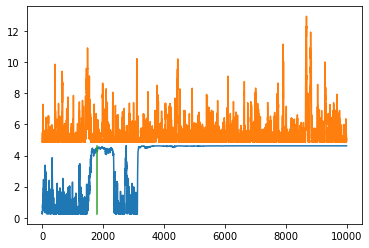

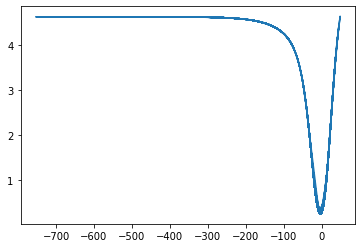

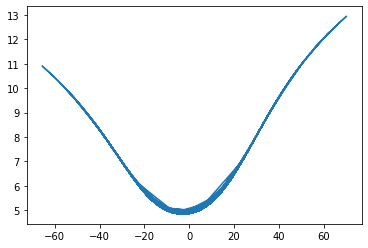

In [91]:
sigma_exp = 0.8

print('max. i: ', len(df[df['sigma_exp'] == sigma_exp]['id_code']))
i = 1

id_code = df[df['sigma_exp'] == 0.4]['id_code'].iloc[i]

df_vals = pandas.read_csv(root_path + id_code + '/input_pars')
df_vals2 = pandas.read_csv(root_path + id_code + '/result_values')
df_vals = pandas.concat([df_vals, df_vals2], axis=1)

en = np.load(root_path + id_code + '/energies_noJef.npy')
en_Jef = np.load(root_path + id_code + '/energies_Jef.npy')

traj = np.load(root_path + id_code + '/lambdas_noJef.npy')
traj_Jef = np.load(root_path + id_code + '/lambdas_Jef.npy')

print(df_vals)

plt.plot(en)
plt.plot(en_Jef)
plt.plot(df_vals['diverg_frame'][0]*np.ones(2), [np.min(en), np.max(en)])

plt.figure()
plt.plot(traj, en)

plt.figure()
plt.plot(traj_Jef, en_Jef)